# Data processing workflow so far   

1) Lowpass filter DAS 1 minute .mseed files at 40Hz    
2) Assemble sliding windows of given size (not done in this example)   
3) Apply additional filter(s) to sliding windows?  
4) Despike, replacing spikes with NaN  
5) Ignore all sliding windows containing NaN    
6) Calculate 16 features (time and freq domain) on each window, for each channel   
7) Assemble the features in some way (use all of them, mean over channels, PCA etc.)  
8) Train a random forest regression   
9) Assess this by graphing prediction performance    

### Training a random forest on features calculated from a sliding window of 30 minutes

The window length is 30mins, window overlap is 5mins. We can train the algorithm on the mean over channels around probe M3_20_Avg, on all channels or on a PCA-derived dataframe of all channels

In [1]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import glob
%matplotlib inline

In [2]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [3]:
feature_files = glob.glob('/home/rmartinshort/Documents/Berkeley/Fiber/data_test/Soil_moisture_predict/rms_sliding_30/*.csv')
feature_dfs = []
for csv_file in feature_files:
    fname = csv_file.split('/')[-1].split('.')[0][:-18]
    df = pd.read_csv(csv_file)
    df.name = fname
    feature_dfs.append(df)

Example of a feature datagframe. Columns are channels. Rows are that feature calculated at each time window

In [4]:
print(feature_dfs[0].name)

mean_rms_fc


In [5]:
lineCSN_M3['TTime'] = lineCSN_M3.index
stime = lineCSN_M3.index[0]
print(op.UTCDateTime(stime))
lineCSN_M3 = lineCSN_M3.assign(tsince_start=lineCSN_M3['TTime'].apply(lambda x: op.UTCDateTime(x) - op.UTCDateTime(stime)))

2016-08-05T18:07:38.000000Z


Generate interpolation functions for the soil moisture and temperature datasets so that they can be sampled at the times associated with each sliding window (the central time of each window)

In [6]:
f_soilM = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['M3_20_Avg_interp'].values)
f_temp = interpolate.interp1d(lineCSN_M3['tsince_start'].values,lineCSN_M3['Temphigh_interp'].values)

### Test 1: Attempt to predict soil moisture and temperature from channel stack

In [7]:
def extract_mean_over_channels(indf,channels_to_drop):
    
    '''Takes an input dataframe, calculates the mean over columns that are not in the list 
    "channels_to_drop". Returns mean dataframe
    '''
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['time']]
    opdf = opdf.assign(mean_col = indf.drop(channels_to_drop,axis=1).mean(axis=1))
    opdf.columns = ['time',newcolname]
    
    return opdf

Calculate the mean over all channels

In [8]:
channels_to_drop = ['time']
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)

for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df

NaNs appear in the columns if either   
a) That 30 minute time window contains missing data  
b) That 30 minute window contains a spike detected by the despiking filter (Bakku 2015)  

In [9]:
merged_df.head(20)

,time,mean_mean_rms_fc,mean_mean_change_rms_fc,mean_peak_welch_rms_fc,mean_abs_energy_rms_fc,mean_kurtosis_rms_fc,mean_interquartile_range_rms_fc,mean_skewness_rms_fc,mean_minimum_rms_fc,mean_median_rms_fc,mean_mean_abs_change_rms_fc,mean_x_crossing_m_rms_fc,mean_cid_ce_rms_fc,mean_root_mean_square_rms_fc,mean_fft_energy_rms_fc,mean_maximum_rms_fc,mean_variance_rms_fc
0,2016-08-05T18:53:01.281914Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-05T18:58:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08-05T19:03:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-08-05T19:08:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-08-05T19:13:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2016-08-05T19:18:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2016-08-05T19:53:23.598811Z,-0.634725,-0.000186,10.000000,8.392325e+07,18.332625,25.616011,-0.203451,-855.200867,-0.561311,31.918699,37576.500,13926.653020,33.972910,8.389500e+07,592.547368,1165.181851
7,2016-08-05T19:58:23.598811Z,-0.622174,0.000235,9.859375,9.368056e+07,16.484640,26.876477,-0.139451,-855.200867,-0.596317,33.755028,37715.100,14716.518423,35.884998,9.365340e+07,601.425187,1300.715807
8,2016-08-05T20:03:23.598811Z,-0.602403,0.000174,9.843750,9.555552e+07,16.988736,26.835830,-0.113767,-855.200867,-0.628666,33.910917,37821.500,14884.366028,36.237023,9.553024e+07,610.510516,1326.778289
9,2016-08-05T20:08:23.598811Z,-0.694001,-0.000260,10.031250,1.068234e+08,33.458226,27.379865,0.019779,-969.127814,-0.673735,35.494483,38189.900,15945.677225,38.364261,1.067907e+08,997.685402,1483.166341


Apply interpolation functions that we created earlier 

In [10]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))

In [11]:
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))

In [12]:
merged_df.head(20)

,time,mean_mean_rms_fc,mean_mean_change_rms_fc,mean_peak_welch_rms_fc,mean_abs_energy_rms_fc,mean_kurtosis_rms_fc,mean_interquartile_range_rms_fc,mean_skewness_rms_fc,mean_minimum_rms_fc,mean_median_rms_fc,mean_mean_abs_change_rms_fc,mean_x_crossing_m_rms_fc,mean_cid_ce_rms_fc,mean_root_mean_square_rms_fc,mean_fft_energy_rms_fc,mean_maximum_rms_fc,mean_variance_rms_fc,tsince_start,M3_20_Avg_interp,Temphigh_interp
0,2016-08-05T18:53:01.281914Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2723.281914,0.202000,26.471626
1,2016-08-05T18:58:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3023.282279,0.202000,26.315293
2,2016-08-05T19:03:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3323.282279,0.202000,26.158960
3,2016-08-05T19:08:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3623.282279,0.202000,26.002628
4,2016-08-05T19:13:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3923.282279,0.202000,25.846295
5,2016-08-05T19:18:01.282279Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4223.282279,0.202000,25.689962
6,2016-08-05T19:53:23.598811Z,-0.634725,-0.000186,10.000000,8.392325e+07,18.332625,25.616011,-0.203451,-855.200867,-0.561311,31.918699,37576.500,13926.653020,33.972910,8.389500e+07,592.547368,1165.181851,6345.598811,0.201611,24.357676
7,2016-08-05T19:58:23.598811Z,-0.622174,0.000235,9.859375,9.368056e+07,16.484640,26.876477,-0.139451,-855.200867,-0.596317,33.755028,37715.100,14716.518423,35.884998,9.365340e+07,601.425187,1300.715807,6645.598811,0.201111,24.138510
8,2016-08-05T20:03:23.598811Z,-0.602403,0.000174,9.843750,9.555552e+07,16.988736,26.835830,-0.113767,-855.200867,-0.628666,33.910917,37821.500,14884.366028,36.237023,9.553024e+07,610.510516,1326.778289,6945.598811,0.201000,23.989423
9,2016-08-05T20:08:23.598811Z,-0.694001,-0.000260,10.031250,1.068234e+08,33.458226,27.379865,0.019779,-969.127814,-0.673735,35.494483,38189.900,15945.677225,38.364261,1.067907e+08,997.685402,1483.166341,7245.598811,0.201000,23.860256


Soil moisture time series to be predicted. Note that there are some gaps in the data

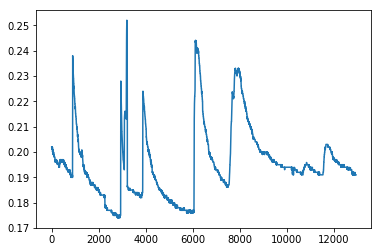

In [13]:
merged_df['M3_20_Avg_interp'].plot()

Remove all rows that contain gaps

In [248]:
cleaned_df = merged_df.dropna()

Train algorithm and assess prediction quality

In [249]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

In [250]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)

In [111]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [112]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.09984339 0.04730252 0.0825819  0.01583297 0.07074524 0.08468823
 0.07513709 0.07132021 0.10622756 0.04372598 0.13191386 0.04140366
 0.02476278 0.01592149 0.07256947 0.01602367]
0.44653614140320375


Print features with the highest importance

In [117]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(5):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.13191385546926554 mean_x_crossing_m_rms_fc
0.10622755795823853 mean_median_rms_fc
0.099843391329641 mean_mean_rms_fc
0.0846882282038692 mean_interquartile_range_rms_fc
0.08258189520089104 mean_peak_welch_rms_fc


None of the features have especially high importance

In [114]:
regr.score(X_test,y_test)

0.42984848443448676

In [115]:
regr_pred = regr.predict(X_test)

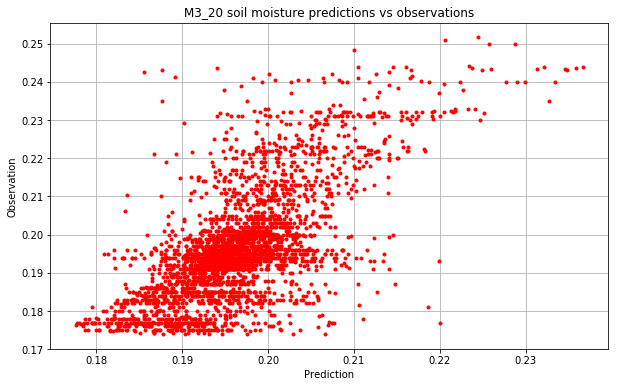

In [116]:
plt.figure(figsize=(10,6))
plt.title('M3_20 soil moisture predictions vs observations')
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_moisture_prediction_sliding_window.png')

The fit is not great, but at least there is a positive correlation that could be improved with better parameter choice or perhaps a different algorithm (such as a neutral network) 

Lets try the same workflow on the temperature timeseries

In [251]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [130]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.09804821 0.0316613  0.1112476  0.01253769 0.08777833 0.06713743
 0.05434542 0.05024754 0.10231132 0.03198212 0.22760205 0.02474168
 0.01862541 0.01180752 0.05769305 0.01223335]
0.6043794886315528


In [141]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(5):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.13152707686599727 mean_x_crossing_m_rms_fc
0.10945098135108158 mean_median_rms_fc
0.10435314390255068 mean_peak_welch_rms_fc
0.10315202516644088 mean_mean_rms_fc
0.08267064763395598 mean_maximum_rms_fc


In [132]:
regr.score(X_test,y_test)

0.6163337580795134

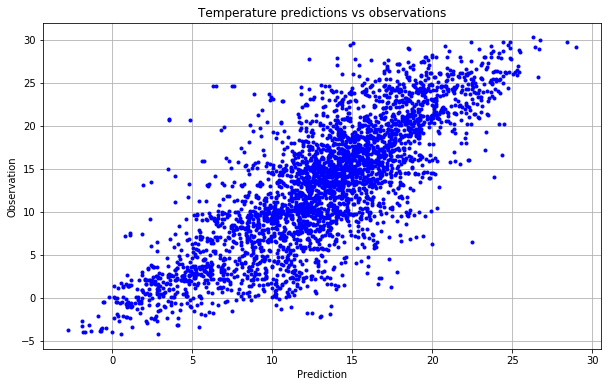

In [133]:
regr_pred = regr.predict(X_test)
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_sliding_window.png')

The temperature feature timeseries shows a clear day/night cycle, although it is very noisy

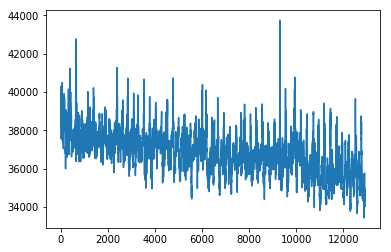

In [252]:
X['mean_x_crossing_m_rms_fc'].plot()

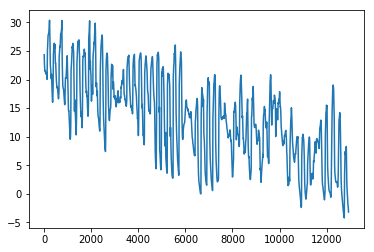

In [253]:
y.plot()

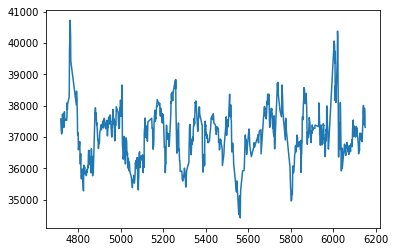

In [264]:
X['mean_x_crossing_m_rms_fc'][4000:5000].plot()

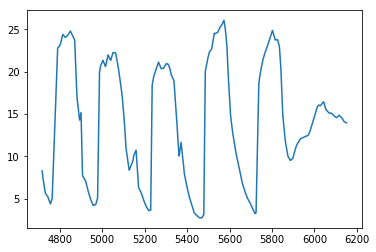

In [260]:
y[4000:5000].plot()

### What about calculating the mean over a smaller set of channels - just the 84,85 and 86, which are closest to the soil moisture probe?

In [136]:
feature_dfs[0].head()

,channel_80,channel_81,channel_82,channel_83,channel_84,channel_85,channel_86,channel_87,channel_88,channel_89,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:53:01.281914Z
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T18:58:01.282279Z
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T19:03:01.282279Z
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T19:08:01.282279Z
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-05T19:13:01.282279Z


In [138]:
channels_to_drop = ['time','channel_80','channel_81','channel_82','channel_83','channel_87','channel_88',
                    'channel_89']
indf = extract_mean_over_channels(feature_dfs[0],channels_to_drop)

for feature_df in feature_dfs[1:]:
    
    mean_feature = extract_mean_over_channels(feature_df,channels_to_drop)
    merged_df = pd.merge(indf,mean_feature,on='time')
    indf = merged_df

In [139]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))
cleaned_df = merged_df.dropna()

In [140]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [142]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.10315203 0.0427258  0.10435314 0.01560317 0.06623167 0.06788312
 0.07553295 0.07669522 0.10945098 0.03862066 0.13152708 0.03784324
 0.01692566 0.01532861 0.08267065 0.01545605]
0.49929055083930174


In [143]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(5):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.13152707686599727 mean_x_crossing_m_rms_fc
0.10945098135108158 mean_median_rms_fc
0.10435314390255068 mean_peak_welch_rms_fc
0.10315202516644088 mean_mean_rms_fc
0.08267064763395598 mean_maximum_rms_fc


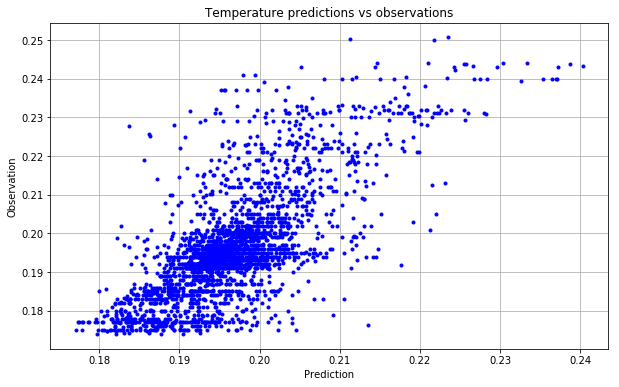

In [144]:
regr.score(X_test,y_test)
regr_pred = regr.predict(X_test)
plt.figure(figsize=(10,6))
plt.title('Temperature predictions vs observations')
plt.plot(regr_pred,y_test,'b.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_sliding_window.png')

The fit is slighty improved over a mean of 10 channels

### Test 2: Attempt to predict soil moisture and temperature using channel-specific features

In [145]:
def extract_specific_channels(indf,channels_to_drop=None):
    
    newchannames = []
    if channels_to_drop:
        opdf = indf.drop(channels_to_drop,axis=1)
    else:
        opdf = indf
    for name in opdf.columns:
        new_name = "%s_%s" %(name,indf.name)
        newchannames.append(new_name)
        
    newchannames[-1] = "time"
    opdf.columns = newchannames
    
    return opdf

In [146]:
odf = extract_specific_channels(feature_dfs[0])
for feature_df in feature_dfs[1:]:
       
    selected_features_df = extract_specific_channels(feature_df)
    
    merged_df = pd.merge(odf,selected_features_df,on='time')
    odf = merged_df

In [147]:
merged_df = merged_df.assign(tsince_start=merged_df['time'].apply(lambda x: op.UTCDateTime(x)-op.UTCDateTime(stime)))
merged_df = merged_df.assign(M3_20_Avg_interp=merged_df['tsince_start'].apply(lambda x: f_soilM(x)))
merged_df = merged_df.assign(Temphigh_interp=merged_df['tsince_start'].apply(lambda x: f_temp(x)))
cleaned_df = merged_df.dropna()

Train algorithm

In [208]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [209]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.00676658 0.00575105 0.00779086 0.00491909 0.00558094 0.01084921
 0.01771355 0.01009954 0.01393077 0.00828762 0.00312071 0.00236038
 0.00236483 0.00221297 0.00228375 0.00209725 0.00245374 0.00238507
 0.0025153  0.00356765 0.00360446 0.00281402 0.05134109 0.02724243
 0.00419201 0.00495682 0.00909187 0.01352615 0.00424215 0.00710327
 0.00348798 0.00183803 0.00125816 0.00130544 0.00137026 0.000896
 0.0010975  0.00103556 0.00157286 0.00179186 0.00666731 0.00548419
 0.00614225 0.00663052 0.00342937 0.0038259  0.0045521  0.00353388
 0.00410369 0.00680889 0.00757095 0.00439583 0.0041465  0.00372598
 0.00511008 0.00313593 0.00255774 0.00355769 0.00546155 0.0053831
 0.01259373 0.01128003 0.01011192 0.0117502  0.00940224 0.01024703
 0.01360555 0.00960407 0.00830252 0.00890507 0.00862048 0.0069339
 0.00729327 0.0065323  0.00739956 0.00882665 0.00622947 0.0054064
 0.0075725  0.008837   0.0117944  0.00570934 0.00739082 0.00526374
 0.00617966 0.00522704 0.00938229 0.00660847 0.00848016 0.00666525


In [154]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(10):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.04032258108174198 channel_82_peak_welch_rms_fc
0.03307779473116595 channel_83_peak_welch_rms_fc
0.022238304428507272 channel_89_x_crossing_m_rms_fc
0.021605339322953013 channel_85_x_crossing_m_rms_fc
0.01916598490241936 channel_87_x_crossing_m_rms_fc
0.018409707613436768 channel_81_cid_ce_rms_fc
0.018304443032795187 channel_81_mean_abs_change_rms_fc
0.017464130577485262 channel_86_x_crossing_m_rms_fc
0.01601510191684833 channel_88_mean_rms_fc
0.01590374132051736 channel_80_mean_abs_change_rms_fc


Its interesting that features from channel 85, which is closest to the probe, do not dominate this list

0.6008654859302272


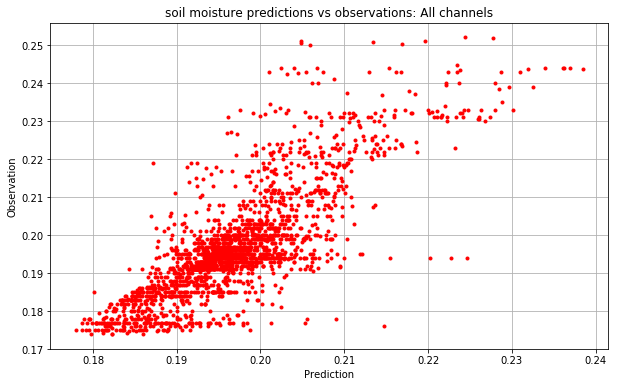

In [156]:
print(regr.score(X_test,y_test))
regr_pred = regr.predict(X_test)
plt.figure(figsize=(10,6))
plt.title('soil moisture predictions vs observations: All channels')
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('soil_M_prediction_all_chan_sliding_window.png')

Using more channels produces better results, but I'm unsure of what this means. This is the best fit to the soil moisture data that we have so far

In [157]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [158]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.01650945 0.005261   0.00522032 0.01185146 0.00502434 0.00495123
 0.00352355 0.00750284 0.00555534 0.01097742 0.00298999 0.00233684
 0.00212013 0.00195229 0.00176166 0.00182982 0.00182775 0.00168615
 0.00222756 0.00252022 0.01502326 0.00693753 0.00237877 0.00802196
 0.0073783  0.04000588 0.0078454  0.03530755 0.00362045 0.00594993
 0.00207965 0.0010317  0.00078926 0.00091314 0.0006925  0.00085881
 0.0009958  0.0009211  0.0008495  0.00099512 0.02535212 0.01559857
 0.0068726  0.00474437 0.0041037  0.00401283 0.00360237 0.00409124
 0.00436511 0.00449874 0.00421411 0.00327357 0.00456831 0.00291307
 0.0033659  0.00464515 0.00255018 0.00251549 0.00219422 0.00302437
 0.0100367  0.00890657 0.00802752 0.00741824 0.00699625 0.00737389
 0.00881361 0.00772152 0.00926542 0.00843574 0.00957335 0.00622952
 0.00485894 0.00542451 0.00499368 0.00477351 0.00412078 0.00536709
 0.00524409 0.00866115 0.01552874 0.00726992 0.00591245 0.00403003
 0.0047743  0.00430305 0.00467561 0.00414093 0.00568124 0.0097

In [159]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(10):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.09308213774736934 channel_87_x_crossing_m_rms_fc
0.08659826028541139 channel_85_x_crossing_m_rms_fc
0.040005875206787826 channel_85_peak_welch_rms_fc
0.035307546902797 channel_87_peak_welch_rms_fc
0.02535212221991616 channel_80_kurtosis_rms_fc
0.021508581904452474 channel_86_x_crossing_m_rms_fc
0.021226472859131443 channel_84_x_crossing_m_rms_fc
0.02030614434371012 channel_80_x_crossing_m_rms_fc
0.01988572058905525 channel_81_x_crossing_m_rms_fc
0.016509453331787743 channel_80_mean_rms_fc


0.7211810238985512


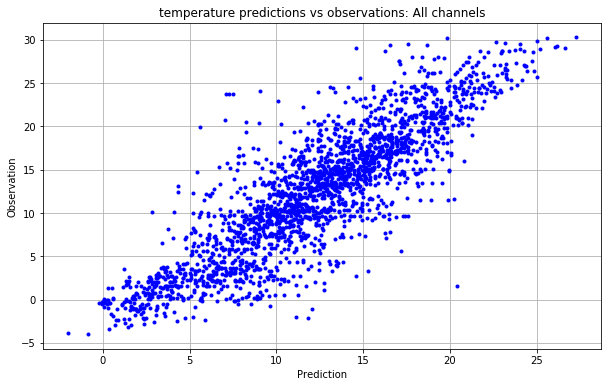

In [160]:
print(regr.score(X_test,y_test))
regr_pred = regr.predict(X_test)
plt.figure(figsize=(10,6))
plt.title('temperature predictions vs observations: All channels')
plt.plot(regr_pred,y_test,'b.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_all_chan_sliding_window.png')

### Test 3: More experimental  - apply scaling and PCA before training  

In [161]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [162]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [165]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.01223125 0.00530047 0.00981592 0.01137268 0.00553724 0.00432678
 0.00436682 0.00389464 0.00507352 0.01152577 0.00276759 0.00222398
 0.00194609 0.0019988  0.00187501 0.00168993 0.00172538 0.00184469
 0.00195033 0.00276008 0.01180467 0.01231205 0.0024611  0.0066268
 0.00392831 0.04243631 0.0103826  0.03489034 0.00462361 0.00324939
 0.00176501 0.00093206 0.00094406 0.00084983 0.00075715 0.00081499
 0.00131168 0.00121076 0.00113861 0.00113531 0.01936487 0.01376035
 0.00673404 0.00533618 0.0031295  0.00396143 0.00384491 0.00401558
 0.00391132 0.00487543 0.00436853 0.00293366 0.00520116 0.0030798
 0.00326437 0.00377692 0.00287316 0.00253333 0.00233999 0.00326363
 0.01110804 0.0085066  0.00858805 0.0078838  0.0066476  0.00807401
 0.00918907 0.0082507  0.00828279 0.00760057 0.00894746 0.00824138
 0.00511003 0.00614706 0.00524755 0.00457203 0.00463067 0.00499294
 0.00488037 0.00851339 0.01938036 0.00621482 0.00552958 0.00496102
 0.00418453 0.0040769  0.00407304 0.00322671 0.00628473 0.013037

In [166]:
inds = np.argsort(regr.feature_importances_)[::-1]

for i in range(10):
    print(regr.feature_importances_[inds[i]],X.columns[inds[i]])

0.0695865072770721 channel_87_x_crossing_m_rms_fc
0.06237524622467874 channel_86_x_crossing_m_rms_fc
0.0596055470896359 channel_85_x_crossing_m_rms_fc
0.04243631184259084 channel_85_peak_welch_rms_fc
0.03489033682952561 channel_87_peak_welch_rms_fc
0.02856222360268162 channel_84_x_crossing_m_rms_fc
0.02260131995355535 channel_80_x_crossing_m_rms_fc
0.019380356433305802 channel_80_median_rms_fc
0.019364869359927497 channel_80_kurtosis_rms_fc
0.017130073891847286 channel_81_x_crossing_m_rms_fc


0.7262043395292791


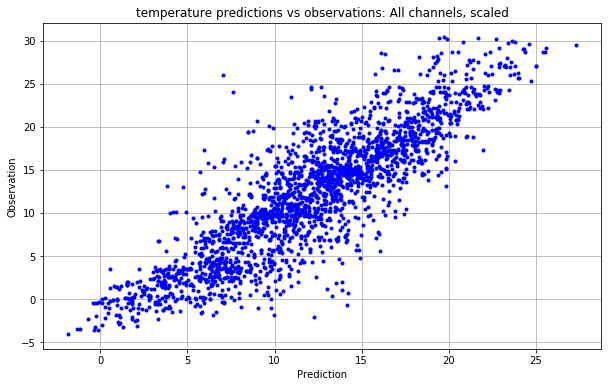

In [167]:
print(regr.score(X_test,y_test))
regr_pred = regr.predict(X_test)
plt.figure(figsize=(10,6))
plt.title('temperature predictions vs observations: All channels, scaled')
plt.plot(regr_pred,y_test,'b.')
plt.xlabel('Prediction')
plt.ylabel('Observation')
plt.grid()
plt.savefig('temperature_prediction_all_chan_scaled_sliding_window.png')

### Attempt to use PCA to understand the feature space

In [227]:
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['time','tsince_start','M3_20_Avg_interp','Temphigh_interp'],axis=1)
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

In [228]:
pca = PCA(n_components=20)
pca.fit(scaled_X)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [229]:
X_pca = pca.transform(scaled_X)

Scree plot to understand the importance of the components

Text(0,0.5,'Eigenvalue')

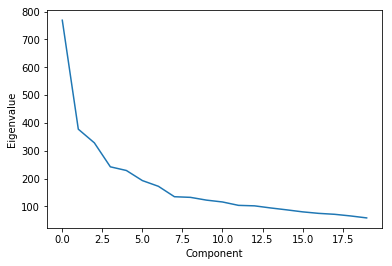

In [235]:
plt.plot(pca.singular_values_)
plt.xlabel('Component')
plt.ylabel('Eigenvalue')

In [236]:
print(pca.explained_variance_ratio_)

[0.49335203 0.11900066 0.09015943 0.04906558 0.04388422 0.03109978
 0.02483325 0.01523294 0.01472213 0.01260263 0.01127855 0.0090413
 0.00873908 0.00750205 0.00646374 0.00544444 0.00473935 0.00431997
 0.00364062 0.00290366]


In [238]:
X_train, X_test, y_train, y_test = train_test_split(X_pca,y,test_size=0.3)
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=1,oob_score=True,n_jobs=2)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [239]:
print(regr.feature_importances_)
print(regr.oob_score_)

[0.07993813 0.08689036 0.05624595 0.08864219 0.02506795 0.07396193
 0.04073471 0.02973165 0.02336472 0.07863484 0.03478052 0.03292998
 0.04341653 0.0338968  0.06151527 0.06867295 0.03801164 0.03717741
 0.03065616 0.03573031]
0.44579174560674417


The fact that training on a small number of PCA components (which together appear to explain the vast majority of the variance in the data) produced a worse fit than when all the channels are used suggests that we might be fitting noise.  